In [1]:
import pandas as pd
import numpy as np
from dsipts import TimeSeries, RNN,read_public_dataset, LinearTS, Persistent
import matplotlib.pyplot as plt
from datetime import timedelta
import logging
import sys
#logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
#logging.debug("info")

/home/agobbi/Projects/TS/dsipts/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#read a public dataset
data, columns = read_public_dataset('/home/agobbi/Projects/ExpTS/data','weather')

In [3]:
data.head()

,time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),y
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2


In [4]:
use_covariates = False  #use only y
use_future_covariate = True #suppose to have some future covariates

In [5]:
##load the timeseries to the datastructure, adding the hour column and use all the covariates
ts = TimeSeries('weather')
ts.load_signal( data,enrich_cat=['hour'],target_variables=['y'],past_variables=columns if use_covariates else [], future_variables=columns if use_future_covariate else [] )


In [6]:
ts


Timeseries named weather of length 52704.
 Categorical variable: ['hour'],
 Future variables: ['wv (m/s)', 'max. PAR (�mol/m�/s)', 'SWDR (W/m�)', 'Tpot (K)', 'max. wv (m/s)', 'PAR (�mol/m�/s)', 'Tlog (degC)', 'rho (g/m**3)', 'VPact (mbar)', 'rh (%)', 'rain (mm)', 'wd (deg)', 'T (degC)', 'raining (s)', 'VPdef (mbar)', 'VPmax (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)', 'p (mbar)', 'sh (g/kg)'],
 Past variables: ['y'],
 Target variables: ['y']
 With no group

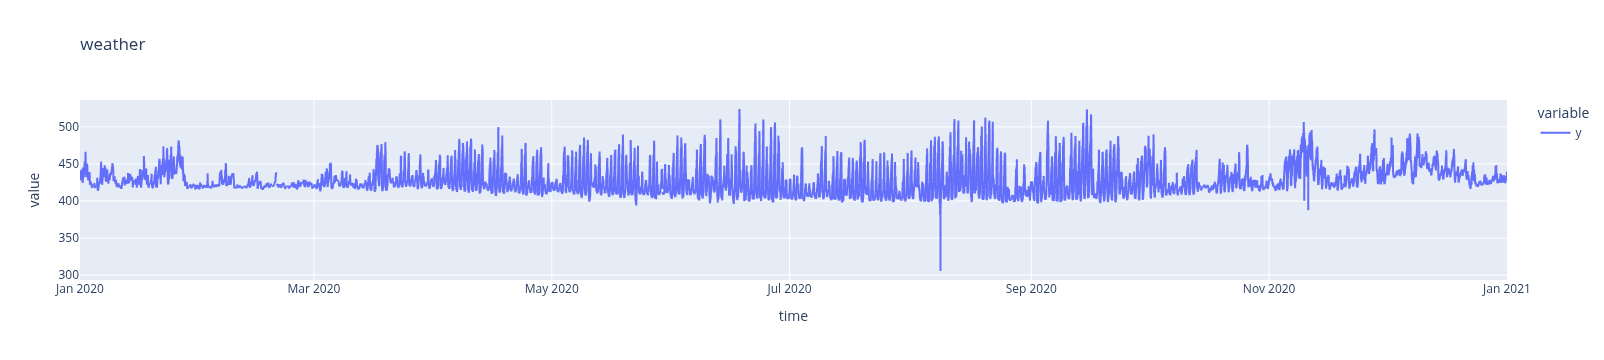

In [7]:
fig = ts.plot()

In [16]:
#RNN
past_steps = 4
future_steps = 8
config = dict(model_configs =dict(

                                    past_steps = past_steps, #TASK DEPENDENT 
                                    future_steps = future_steps,#TASK DEPENDENT  
    
                                    emb_dim = 8, # categorical stuff
                                    use_classical_positional_encoder = True, # categorical stuff
                                    reduction_mode = 'mean',# categorical stuff
    
                                    kind = 'gru',# model dependent
                                    hidden_RNN = 12,# model dependent
                                    num_layers_RNN = 2,# model dependent
                                    kernel_size = 15,# model dependent
                                    dropout_rate= 0.5,# model dependent
                                    remove_last= True,# model dependent
                                    use_bn = False,# model dependent
                                    activation= 'torch.nn.PReLU', # model dependent
    
                                    quantiles=[0.1,0.5,0.9], #LOSS
                                    persistence_weight= 0.010, #LOSS
                                    loss_type= 'l1', #LOSS
    
                                    optim= 'torch.optim.Adam', #OPTIMIZER
    
                                    past_channels = len(ts.past_variables), #parameter that depends on the ts dataset
                                    future_channels = len(ts.future_variables), #parameter that depends on the ts dataset
                                    embs_past = [ts.dataset[c].nunique() for c in ts.cat_past_var], #parameter that depends on the ts dataset
                                    embs_fut = [ts.dataset[c].nunique() for c in ts.cat_fut_var], #parameter that depends on the ts dataset
                                    out_channels = len(ts.target_variables)),             #parameter that depends on the ts dataset
              
                scheduler_config = dict(gamma=0.1,step_size=100),
                optim_config = dict(lr = 0.0005,weight_decay=0.01))
model_rnn = RNN(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'],verbose=True )


In [17]:
#set the desirere model
ts.set_model(model_rnn,config=config)

In [18]:
##splitting parameters
split_params = {'perc_train':0.7,'perc_valid':0.1,                             ##if not None it will split 70% 10% 20%
               'range_train':None, 'range_validation':None, 'range_test':None, ## or we can split using ranges for example range_train=['2021-02-03','2022-04-08']
               'past_steps':past_steps,
               'future_steps':future_steps,
               'starting_point':None,                                          ## do not skip samples
               'skip_step' : 1                                                 ## distance between two consecutive samples
                             }

In [23]:
#train the model for 50 epochs with auto_lr_find 
if True:
    ts.train_model(dirpath=f"/home/agobbi/Projects/ExpTS/tmp/test",
                   split_params=split_params,
                   batch_size=128,
                   num_workers=4,
                   max_epochs=5,
                   gradient_clip_val= 0.0,
                   gradient_clip_algorithm='value',
                   precision='bf16',
                   auto_lr_find=True)
    #Print the losses, check overfitting
    ts.save(f"weather")

Seed set to 42
/home/agobbi/Projects/TS/dsipts/.venv/lib/python3.11/site-packages/lightning/fabric/connector.py:571: UserWarning:

`precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!

INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/agobbi/Projects/TS/dsipts/.venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: UserWarning:

Checkpoint directory /home/agobbi/Projects/ExpTS/tmp/test exists and is not empty.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/tmp/test/last.ckpt
/home/agobbi/Projects/TS/dsipts/.venv/lib/python3.11/

Saving losses on file because multigpu not working


In [ ]:
#make inferences on 
retrain=False
if retrain:
    res = ts.inference_on_set(200,4,set='test',rescaling=True)
    import numpy as np
    res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 

In [ ]:
## get the median MSE for each lag


In [ ]:
#save model 


In [ ]:
## load the model and check if we obtain the same result

In [ ]:
data

In [26]:
ts.load(RNN,f"weather",load_last=True)
res = ts.inference_on_set(200,4,set='test',rescaling=True)
error = res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 
error

/tmp/ipykernel_23215/3884592559.py:3: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,lag,error
0,1,6.334977
1,2,11.386857
2,3,15.247707
3,4,18.725588
4,5,22.280752
5,6,26.293003
6,7,30.527214
7,8,34.675072


<Axes: xlabel='lag'>

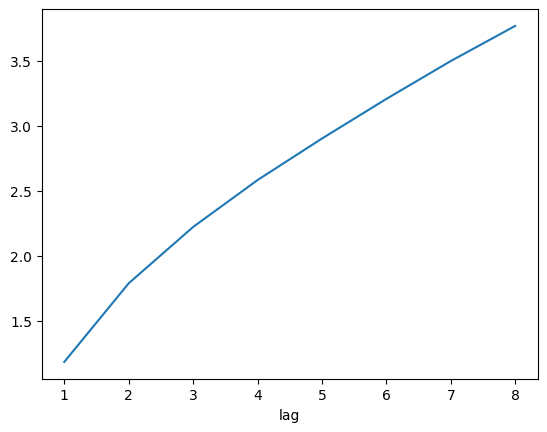

In [44]:
import numpy as np
res['error'] =np.abs( res['y']-res['y_median'])
res.groupby('lag').error.mean().plot()

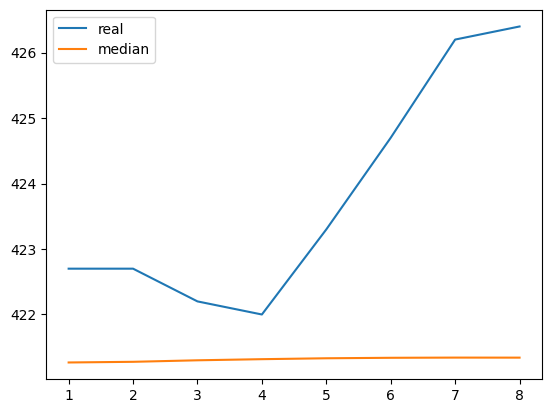

In [42]:
import matplotlib.pyplot as plt
mask = res.prediction_time=='2020-10-19 19:50:00'   
plt.plot(res.lag[mask],res.y[mask],label='real')
plt.plot(res.lag[mask],res.y_median[mask],label='median')
plt.legend()

In [ ]:
##print the mean MSE along the lag steps
#plt.plot(error.lag,error.error)

In [40]:
res

,lag,time,y,y_low,y_median,y_high,prediction_time
0,1,2020-10-19 20:00:00,422.700012,436.407867,421.266968,410.032318,2020-10-19 19:50:00
1,1,2020-10-19 20:10:00,422.700012,437.606750,422.467468,411.232880,2020-10-19 20:00:00
2,1,2020-10-19 20:20:00,422.200012,437.605560,422.467407,411.234009,2020-10-19 20:10:00
3,1,2020-10-19 20:30:00,422.000000,437.105194,421.967651,410.733948,2020-10-19 20:20:00
4,1,2020-10-19 20:40:00,423.299988,436.906250,421.767792,410.533264,2020-10-19 20:30:00
...,...,...,...,...,...,...,...
84227,8,2020-12-31 23:10:00,431.299988,446.923920,431.855713,420.580353,2020-12-31 21:50:00
84228,8,2020-12-31 23:20:00,433.000000,447.424500,432.356812,421.080536,2020-12-31 22:00:00
84229,8,2020-12-31 23:30:00,439.600006,447.324799,432.257355,420.980621,2020-12-31 22:10:00
84230,8,2020-12-31 23:40:00,435.200012,447.823303,432.753662,421.479858,2020-12-31 22:20:00


In [31]:
tmp = data[data.time>'2020-12-28 12:00:00']
tmp['hour'] = tmp.time.dt.hour

empty = pd.DataFrame({'time':pd.date_range(tmp.time.max()+timedelta(hours=1),tmp.time.max()+timedelta(hours=future_steps),freq='1h'),
                      'y':np.nan}) ##this is a bug, you can 
empty['hour'] = empty.time.dt.hour
inference_data = pd.concat([tmp,empty])

In [32]:
tmp

,time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),y,hour
52192,2020-12-28 12:10:00,956.55,3.62,280.31,-0.58,73.87,7.92,5.85,2.07,3.81,...,4.22,187.3,0.0,0.0,146.57,284.93,436.81,13.56,427.1,12
52193,2020-12-28 12:20:00,956.37,3.86,280.57,-0.50,73.11,8.06,5.89,2.17,3.84,...,4.04,173.3,0.0,0.0,219.90,414.01,487.15,13.70,426.8,12
52194,2020-12-28 12:30:00,956.21,4.13,280.86,-0.42,72.09,8.21,5.92,2.29,3.86,...,4.41,175.1,0.0,0.0,207.25,392.72,436.75,13.85,426.8,12
52195,2020-12-28 12:40:00,956.14,4.23,280.96,-0.46,71.42,8.27,5.91,2.36,3.85,...,5.08,165.8,0.0,0.0,175.70,335.88,388.82,14.04,426.9,12
52196,2020-12-28 12:50:00,956.03,4.16,280.90,-0.52,71.42,8.23,5.88,2.35,3.83,...,4.51,156.8,0.0,0.0,121.36,236.78,274.23,14.19,426.9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52691,2020-12-31 23:20:00,978.32,2.28,277.16,-0.80,80.00,7.20,5.76,1.44,3.67,...,1.40,180.6,0.0,0.0,0.00,0.00,0.00,13.40,433.0,23
52692,2020-12-31 23:30:00,978.30,2.13,277.01,-0.43,83.10,7.12,5.92,1.20,3.77,...,0.82,174.0,0.0,0.0,0.00,0.00,0.00,13.42,439.6,23
52693,2020-12-31 23:40:00,978.26,1.99,276.88,-0.71,82.20,7.05,5.80,1.26,3.69,...,0.76,248.9,0.0,0.0,0.00,0.00,0.00,13.45,435.2,23
52694,2020-12-31 23:50:00,978.26,2.07,276.95,-0.77,81.40,7.09,5.77,1.32,3.68,...,1.07,196.6,0.0,0.0,0.00,0.00,0.00,13.47,433.9,23


In [33]:
inference_data ##I can extend the dataset

,time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),y,hour
52192,2020-12-28 12:10:00,956.55,3.62,280.31,-0.58,73.87,7.92,5.85,2.07,3.81,...,4.22,187.3,0.0,0.0,146.57,284.93,436.81,13.56,427.1,12
52193,2020-12-28 12:20:00,956.37,3.86,280.57,-0.50,73.11,8.06,5.89,2.17,3.84,...,4.04,173.3,0.0,0.0,219.90,414.01,487.15,13.70,426.8,12
52194,2020-12-28 12:30:00,956.21,4.13,280.86,-0.42,72.09,8.21,5.92,2.29,3.86,...,4.41,175.1,0.0,0.0,207.25,392.72,436.75,13.85,426.8,12
52195,2020-12-28 12:40:00,956.14,4.23,280.96,-0.46,71.42,8.27,5.91,2.36,3.85,...,5.08,165.8,0.0,0.0,175.70,335.88,388.82,14.04,426.9,12
52196,2020-12-28 12:50:00,956.03,4.16,280.90,-0.52,71.42,8.23,5.88,2.35,3.83,...,4.51,156.8,0.0,0.0,121.36,236.78,274.23,14.19,426.9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,2021-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,2021-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,2021-01-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,2021-01-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


In [35]:
ts.inference(data = inference_data,is_inference=True)

,lag,time,y,y_low,y_median,y_high,prediction_time
0,1,2020-12-28 12:50:00,426.899994,441.807343,426.668457,415.433044,2020-12-28 12:40:00
1,1,2020-12-28 13:00:00,427.399994,441.807312,426.668427,415.433075,2020-12-28 12:50:00
2,1,2020-12-28 13:10:00,426.899994,442.308105,427.168182,415.932892,2020-12-28 13:00:00
3,1,2020-12-28 13:20:00,426.200012,441.809540,426.667908,415.431946,2020-12-28 13:10:00
4,1,2020-12-28 13:30:00,426.299988,441.109344,425.968018,414.731934,2020-12-28 13:20:00
...,...,...,...,...,...,...,...
3939,8,2020-12-31 23:20:00,433.000000,447.424500,432.356812,421.080536,2020-12-31 22:00:00
3940,8,2020-12-31 23:30:00,439.600006,447.324799,432.257355,420.980621,2020-12-31 22:10:00
3941,8,2020-12-31 23:40:00,435.200012,447.823303,432.753662,421.479858,2020-12-31 22:20:00
3942,8,2020-12-31 23:50:00,433.899994,446.624390,431.556366,420.280426,2020-12-31 22:30:00


In [36]:
tmp ##or just start from it and DSIPTS will automatically add categorical temporal variable

,time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),y,hour
52192,2020-12-28 12:10:00,956.55,3.62,280.31,-0.58,73.87,7.92,5.85,2.07,3.81,...,4.22,187.3,0.0,0.0,146.57,284.93,436.81,13.56,427.1,12
52193,2020-12-28 12:20:00,956.37,3.86,280.57,-0.50,73.11,8.06,5.89,2.17,3.84,...,4.04,173.3,0.0,0.0,219.90,414.01,487.15,13.70,426.8,12
52194,2020-12-28 12:30:00,956.21,4.13,280.86,-0.42,72.09,8.21,5.92,2.29,3.86,...,4.41,175.1,0.0,0.0,207.25,392.72,436.75,13.85,426.8,12
52195,2020-12-28 12:40:00,956.14,4.23,280.96,-0.46,71.42,8.27,5.91,2.36,3.85,...,5.08,165.8,0.0,0.0,175.70,335.88,388.82,14.04,426.9,12
52196,2020-12-28 12:50:00,956.03,4.16,280.90,-0.52,71.42,8.23,5.88,2.35,3.83,...,4.51,156.8,0.0,0.0,121.36,236.78,274.23,14.19,426.9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52691,2020-12-31 23:20:00,978.32,2.28,277.16,-0.80,80.00,7.20,5.76,1.44,3.67,...,1.40,180.6,0.0,0.0,0.00,0.00,0.00,13.40,433.0,23
52692,2020-12-31 23:30:00,978.30,2.13,277.01,-0.43,83.10,7.12,5.92,1.20,3.77,...,0.82,174.0,0.0,0.0,0.00,0.00,0.00,13.42,439.6,23
52693,2020-12-31 23:40:00,978.26,1.99,276.88,-0.71,82.20,7.05,5.80,1.26,3.69,...,0.76,248.9,0.0,0.0,0.00,0.00,0.00,13.45,435.2,23
52694,2020-12-31 23:50:00,978.26,2.07,276.95,-0.77,81.40,7.09,5.77,1.32,3.68,...,1.07,196.6,0.0,0.0,0.00,0.00,0.00,13.47,433.9,23


In [37]:
ts.inference(data = tmp,steps_in_future=future_steps,is_inference=True)

,lag,time,y,y_low,y_median,y_high,prediction_time
0,1,2020-12-28 12:50:00,426.899994,441.807343,426.668457,415.433044,2020-12-28 12:40:00
1,1,2020-12-28 13:00:00,427.399994,441.807312,426.668427,415.433075,2020-12-28 12:50:00
2,1,2020-12-28 13:10:00,426.899994,442.308105,427.168182,415.932892,2020-12-28 13:00:00
3,1,2020-12-28 13:20:00,426.200012,441.809540,426.667908,415.431946,2020-12-28 13:10:00
4,1,2020-12-28 13:30:00,426.299988,441.109344,425.968018,414.731934,2020-12-28 13:20:00
...,...,...,...,...,...,...,...
3939,8,2020-12-31 23:20:00,433.000000,447.424500,432.356812,421.080536,2020-12-31 22:00:00
3940,8,2020-12-31 23:30:00,439.600006,447.324799,432.257355,420.980621,2020-12-31 22:10:00
3941,8,2020-12-31 23:40:00,435.200012,447.823303,432.753662,421.479858,2020-12-31 22:20:00
3942,8,2020-12-31 23:50:00,433.899994,446.624390,431.556366,420.280426,2020-12-31 22:30:00


better to have qt, i will reduce the dataset


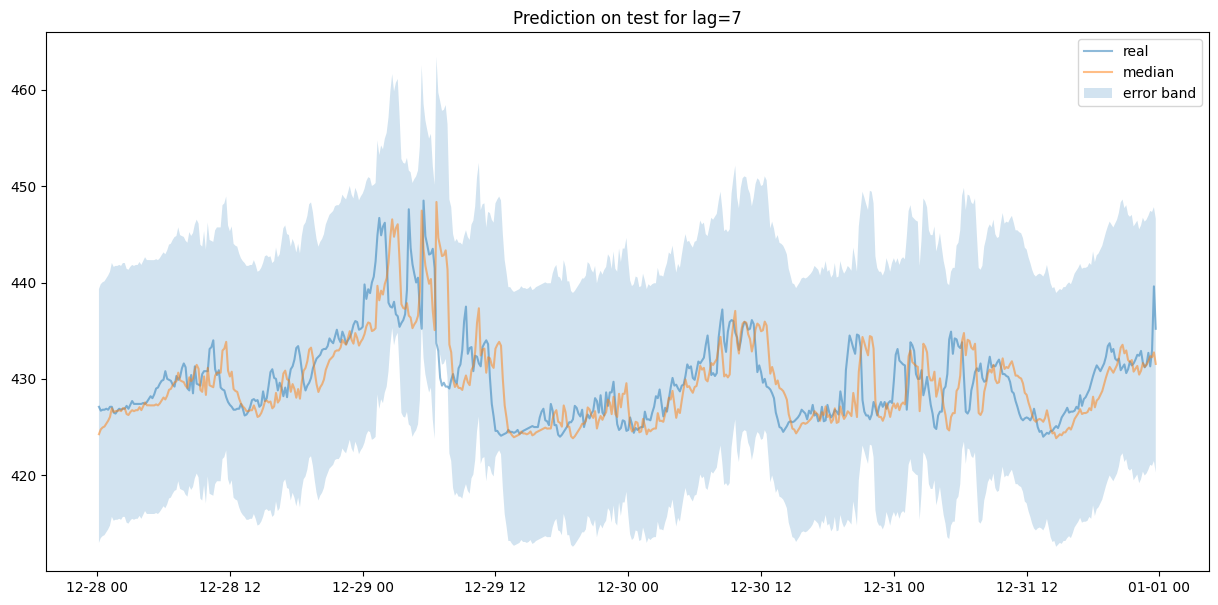

In [38]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = res
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = res[res.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_median,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()